# Assignment 2 - DES simulation
#### Multiple Queues and Multiple Servers

For this assignment, we'll be using the following notation:
- $\lambda$ - the arrival rate into the system as a whole.
- $\mu$ - the capacity of each of $n$ equal servers.
- $\rho$ represents the system load. In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$
- In a multi-server system (one queue with $n$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n\mu}$.

Queuing theory tells us that for FIFO scheduling, the average waiting times are shorter for an $M/M/n$ queue and a system load $\rho$ and processor capacity $\mu$ than for a single $M/M/1$ queue with the same load characteristics (and thus an $n$-fold lower arrival rate). Of course, $\rho$ must be less than one, but the experiment only becomes interesting when $\rho$ is not much less than one.

1. Look up and/or derive this theoretical result, at least for $n = 2$. Describe how it is derived. Can you also give a non-mathematical explanation?
2. Write a DES program to verify this for $n = 1, n = 2$, and $n = 4$. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on $\rho$?
3. Also compare the result to that for an $M/M/1$ queue with shortest job first scheduling, where you always give priority to the smallest jobs.
4. Now experiment with different service rate distributions. On the one hand, try the $M/D/1$ and $M/D/n$ queues; on the other hand, try a long-tail distribution. For the latter, you may, for example, use a distribution where 75% of the jobs have an exponential distribution with an average service time of 1.0, and the remaining 25% have an exponential distribution with an average service time of 5.0 (an example of a hyperexponential distribution). Write your program using SimPy.



--------
### 1. Proof
From Little's Law follows: $E(W) = \frac{E(L^q)}{\lambda}$


--------
### 2. Explanation
Firstly, we have create the framework for a M/M/n queue in the form of a bank with counters and customers. To estimate the true average waiting time $\theta_n$ (depends on n), we proceed to run the simulation for 500 seconds and for $n \in \{1,2,4\}$, for as many repetitions as required to get the average waiting time estimate (mean) within 3 seconds of the true value with 95% confidence. With:

$$ \bar{X}_j = \frac{\sum_{i=1}^{j} X_i}{j} \text{ and } S_j^2 = \frac{\sum_{i=1}^{j} (X_i - \bar{X}_j)^2}{j-1}  $$
 
the sample mean and sample variance of j data values respectively, we keep doing additional simulations (after the first 100) and thus increasing j until the data satisfy $\frac{1.96S}{\sqrt{k}} < 3$. Satisfying this inequality means that the true mean falls within the confidence interval $[\bar{X}_j - 3, \bar{X}_j + 3 ]$ with 95% probability.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import simpy
import itertools

from scipy.stats import norm

In [35]:
class Bank:
    """
    A bank has a limited number of counters (``NUM_COUNTERS``) to serve customers in parallel.
    """

    def __init__(self, env, num_counters, service_rate, priority="FIFO"):
        """
        Initialize the bank with a number of counters (``NUM_COUNTERS``) and a service rate (``SERVICE_RATE``).
        priority: FIFO, SJF (shortest job first).

        If shortest job first is used, we require a priorityResource
        """
        self.env = env

        match priority:
            case "FIFO":
                self.counter = simpy.Resource(env, num_counters)
            case "SJF":
                self.counter = simpy.PriorityResource(env, num_counters)
            case _:
                raise ValueError(f"Priority {priority} not supported")

        self.priority = priority
        self.service_rate = service_rate
        self.customers_served = 0
        self.waiting_times = []
        self.service_times = []
    
    def serve(self, customer, waiting_time, service_time):
        """
        The customer is served for a certain amount of time.
        """
        self.customers_served += 1
        self.waiting_times.append(waiting_time)
        self.service_times.append(service_time)
        yield self.env.timeout(service_time)

def setup(env, bank, sim_time, arrival_rate, print_all=False):
    """
    Create new customers until the sim_time reaches a certain value.
    Specify the customer function to use so that different queueing disciplines can be simulated.
    """
    customer_count = itertools.count()

    # Create more cars while the simulation is running
    while env.now < sim_time:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, f'Customer {next(customer_count)}', bank, print_all=print_all))
    

def customer(env, name, bank, print_all=False):
    """
    Customer arrives, is served and leaves.
    priority: FIFO, SJF (shortest job first). 
    """
    arrive = env.now

    # Computer service time here, so it can later be used as priority
    service_time = random.expovariate(bank.service_rate)

    if print_all:
        print(f"{env.now:.4f} {name}: Arrived (my service time is {service_time:.4f})")
        # print('%7.4f %s: Here I am' % (arrive, name))

    # Check what type of  request to make
    match bank.priority:
        case "FIFO":
            request = bank.counter.request()
        case "SJF":
            request = bank.counter.request(priority=service_time)

    with request as req:
        yield req
        wait = env.now - arrive

        if print_all:
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

        yield env.process(bank.serve(name, wait, service_time))

        if print_all:
            print('%7.4f %s: Finished' % (env.now, name))

# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU)

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")


M/M/1 queue simulation with λ=0.08333333333333333, μ=0.1, ρ = 0.8333333333333333
Simulation time: 50
12.2407 Customer 0: Arrived (my service time is 3.2162)
12.2407 Customer 0: Waited  0.000
12.5447 Customer 1: Arrived (my service time is 13.3359)
15.4570 Customer 0: Finished
15.4570 Customer 1: Waited  2.912
15.5757 Customer 2: Arrived (my service time is 22.2729)
28.7929 Customer 1: Finished
28.7929 Customer 2: Waited 13.217
29.1258 Customer 3: Arrived (my service time is 5.4805)
30.2172 Customer 4: Arrived (my service time is 2.4672)
30.5802 Customer 5: Arrived (my service time is 0.2689)
39.0272 Customer 6: Arrived (my service time is 10.4949)
41.6875 Customer 7: Arrived (my service time is 2.4903)
51.0658 Customer 2: Finished
51.0658 Customer 3: Waited 21.940
51.1354 Customer 8: Arrived (my service time is 8.8981)
56.5462 Customer 3: Finished
56.5462 Customer 4: Waited 26.329
59.0134 Customer 4: Finished
59.0134 Customer 5: Waited 28.433
59.2823 Customer 5: Finished
59.2823 Custom

In [31]:
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate
LOAD = 0.99 # Load factor

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

for n in [1, 2, 4]:
    avg_customers_served = []
    avg_waiting_times = []
    avg_service_times = []

    while True:
        LAMBDA = MU * LOAD * n

        env = simpy.Environment()
        bank = Bank(env, n, MU)

        env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
        env.run()

        avg_customers_served.append(bank.customers_served)
        avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))
        avg_service_times.append(sum(bank.service_times)/len(bank.service_times))

        # Only start checking after 100 repetitions
        if len(avg_waiting_times) < 100:
            continue

        # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
        S = np.std(avg_waiting_times, ddof=1)

        if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
            break

    # Print results
    print(f"M/M/{n} queue simulation with λ = {round(LAMBDA, decimals)}, μ = {round(MU, decimals)}, ρ = {round(LOAD, decimals)} ({len(avg_waiting_times)} repetitions to reach 95% confidence)")
    print(f"Customers served: {round(np.mean(avg_customers_served), decimals)}")
    print(f"Average waiting time: {round(np.mean(avg_waiting_times), decimals)} s")
    # print(f"Average service time: {round(np.mean(avg_service_times), decimals)} s\n")

M/M/1 queue simulation with λ = 0.0825, μ = 0.0833, ρ = 0.99 (645 repetitions to reach 95% confidence)
Customers served: 42.245
Average waiting time: 48.477 s
M/M/2 queue simulation with λ = 0.165, μ = 0.0833, ρ = 0.99 (250 repetitions to reach 95% confidence)
Customers served: 82.816
Average waiting time: 31.4244 s
M/M/4 queue simulation with λ = 0.33, μ = 0.0833, ρ = 0.99 (108 repetitions to reach 95% confidence)
Customers served: 166.8611
Average waiting time: 23.653 s


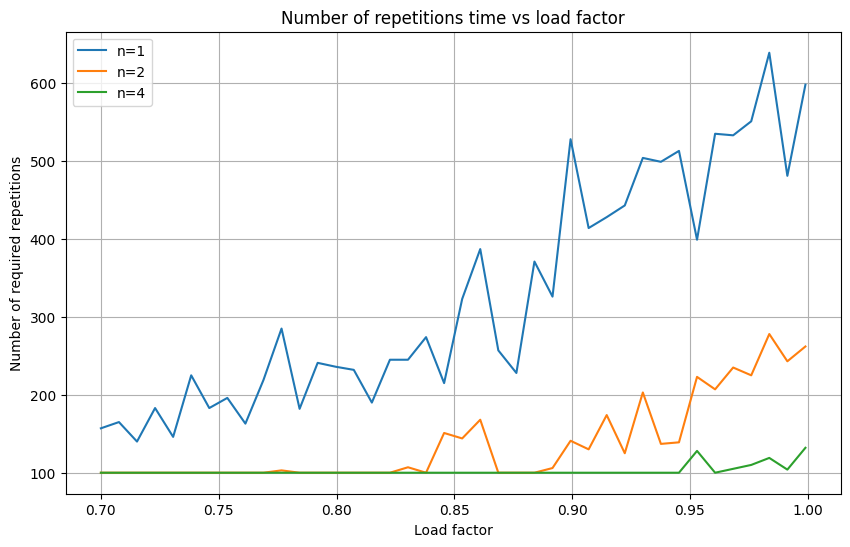

In [42]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 3
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for n in [1, 2, 4]:
    for LOAD in np.linspace(0.7, 0.999, 40):
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 100:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }

results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Number of repetitions time vs load factor")
plt.xlabel("Load factor")
plt.ylabel("Number of required repetitions")
plt.grid()
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1")
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2")
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4")
plt.legend()
plt.show()


In [5]:
results

,n,load,avg_customers_served,avg_waiting_time,repetitions
-1,1,0.700000,30.326241,20.239488,141
0,2,0.700000,59.840000,10.498237,100
1,4,0.700000,117.750000,3.689409,100
2,1,0.707667,30.425926,18.929886,108
3,2,0.707667,58.330000,9.131270,100
...,...,...,...,...,...
114,2,0.991333,83.283951,31.798043,243
115,4,0.991333,165.920000,21.414622,100
116,1,0.999000,42.544369,48.800595,586
117,2,0.999000,83.875000,33.521247,296


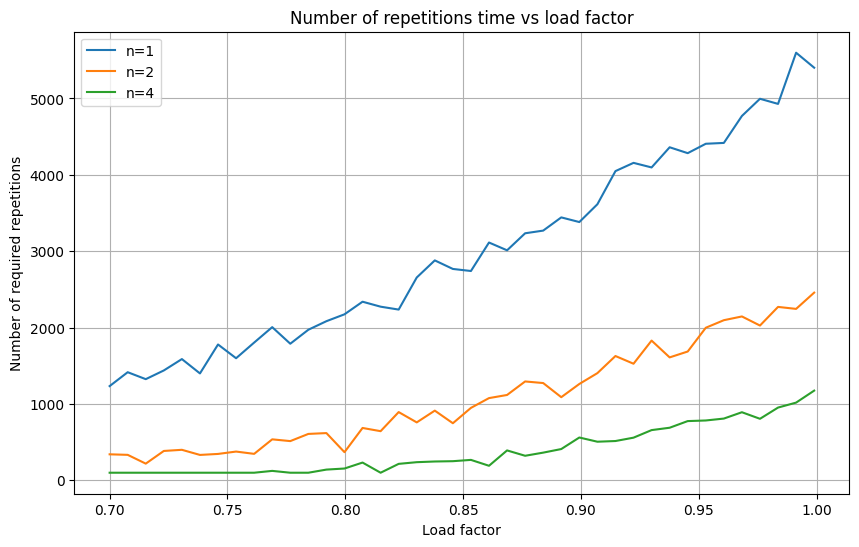

In [6]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for n in [1, 2, 4]:
    for LOAD in np.linspace(0.7, 0.999, 40):
        avg_customers_served = []
        avg_waiting_times = []
        
        while True:
            LAMBDA = MU * LOAD * n

            env = simpy.Environment()
            bank = Bank(env, n, MU)

            env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
            env.run()

            avg_customers_served.append(bank.customers_served)
            avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

            # Only start checking after 100 repetitions
            if len(avg_waiting_times) < 100:
                continue

            # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
            S = np.std(avg_waiting_times, ddof=1)

            if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                break
        
        results.loc[len(results) - 1] = {
            'n': n,
            'load': LOAD,
            'avg_customers_served': np.mean(avg_customers_served),
            'avg_waiting_time': np.mean(avg_waiting_times),
            'repetitions': len(avg_waiting_times)
        }

results_n1 = results[results['n'] == 1]
results_n2 = results[results['n'] == 2]
results_n4 = results[results['n'] == 4]

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Number of repetitions time vs load factor")
plt.xlabel("Load factor")
plt.ylabel("Number of required repetitions")
plt.grid()
plt.plot(results_n1['load'], results_n1['repetitions'], label="n=1")
plt.plot(results_n2['load'], results_n2['repetitions'], label="n=2")
plt.plot(results_n4['load'], results_n4['repetitions'], label="n=4")
plt.legend()
plt.show()

--------
### 3. Explanation
For the shortest job first scheduling, we edited the initial class 'Bank' and function 'customer'. The 'Bank' class now has a 'priority' parameter that takes either "FIFO" or "SJF" and changes the counter 'simpy.Resource' to a 'simpy.PriorityResource' if its an SJF. The 'customer' function checks the priority from the bank object, and if this is an "SJF" bank, it creates requests with priority equal to the predetermined service time. Since smaller priority values are put at the front of the line, this means that the shortest job is serviced first.

In the next code block we give an example usage (seed = 42). Customers 3, 4, 5, 6 and 7 all arrive during customer 2's (considerable) service time. After customer 2 is finished, customer 5 is serviced first since they have the lowest service time (0.2689). Customers 4, 7 and 3 follow shortly, also in order of shortest service time.

When comparing the load to the number of repetitions required to reach the 95% significance, we change the confidence interval radius to 1 because the SJF queues turned out to reach the 95% significance within 50 repetitions in a lot of cases.

In [40]:
# Example usage:
RANDOM_SEED = 42
LAMBDA = 1/12 # Arrival rate
MU = 1/10 # Service rate
SIMULATION_TIME = 50
n = 1 # Number of counters

LOAD = LAMBDA/(MU * n) # Load of the system, should be < 1 for stable system

print(f"M/M/1 queue simulation with λ={LAMBDA}, μ={MU}, ρ = {LOAD}")
print(f"Simulation time: {SIMULATION_TIME}")

random.seed(RANDOM_SEED)
env = simpy.Environment()

bank = Bank(env, n, MU, priority="SJF")

env.process(setup(env, bank, SIMULATION_TIME, LAMBDA, print_all=True))
env.run()

print(f"Customers served: {bank.customers_served}")
print(f"Average waiting time: {sum(bank.waiting_times)/len(bank.waiting_times)}")

M/M/1 queue simulation with λ=0.08333333333333333, μ=0.1, ρ = 0.8333333333333333
Simulation time: 50
12.2407 Customer 0: Arrived (my service time is 3.2162)
12.2407 Customer 0: Waited  0.000
12.5447 Customer 1: Arrived (my service time is 13.3359)
15.4570 Customer 0: Finished
15.4570 Customer 1: Waited  2.912
15.5757 Customer 2: Arrived (my service time is 22.2729)
28.7929 Customer 1: Finished
28.7929 Customer 2: Waited 13.217
29.1258 Customer 3: Arrived (my service time is 5.4805)
30.2172 Customer 4: Arrived (my service time is 2.4672)
30.5802 Customer 5: Arrived (my service time is 0.2689)
39.0272 Customer 6: Arrived (my service time is 10.4949)
41.6875 Customer 7: Arrived (my service time is 2.4903)
51.0658 Customer 2: Finished
51.0658 Customer 5: Waited 20.486
51.1354 Customer 8: Arrived (my service time is 8.8981)
51.3347 Customer 5: Finished
51.3347 Customer 4: Waited 21.118
53.8019 Customer 4: Finished
53.8019 Customer 7: Waited 12.114
56.2921 Customer 7: Finished
56.2921 Custom

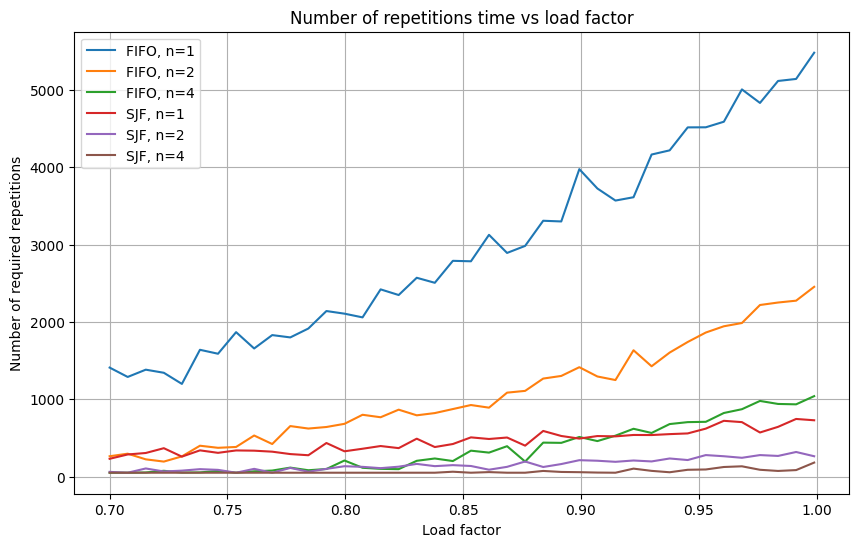

In [47]:
# Number of measurements vs load factor
RANDOM_SEED = 42
SIMULATION_TIME = 500

MU = 1/12 # Service rate

# We repeat until the average waiting time estimate is within 3 second of the true value (95% confidence)
alpha = 0.05
CI_radius = 1
z = norm.ppf(1-alpha/2) # 1.96 for 95% confidence

decimals = 4 # Number of decimals in results

random.seed(RANDOM_SEED)

results = pd.DataFrame(columns=['priority', 'n', 'load', 'avg_customers_served', 'avg_waiting_time', 'repetitions'])

for priority in ['FIFO', 'SJF']:
    for n in [1, 2, 4]:
        for LOAD in np.linspace(0.7, 0.999, 40):
            avg_customers_served = []
            avg_waiting_times = []
            
            while True:
                LAMBDA = MU * LOAD * n

                env = simpy.Environment()
                bank = Bank(env, n, MU, priority=priority)

                env.process(setup(env, bank, SIMULATION_TIME, LAMBDA))
                env.run()

                avg_customers_served.append(bank.customers_served)
                avg_waiting_times.append(sum(bank.waiting_times)/len(bank.waiting_times))

                # Only start checking after 100 repetitions
                if len(avg_waiting_times) < 50:
                    continue

                # Check if the 1-alpha % confidence interval is within CI_radius seconds of the true value
                S = np.std(avg_waiting_times, ddof=1)

                if z * S/np.sqrt(len(avg_waiting_times)) < CI_radius:
                    break
            
            results.loc[len(results) - 1] = {
                'priority': priority,
                'n': n,
                'load': LOAD,
                'avg_customers_served': np.mean(avg_customers_served),
                'avg_waiting_time': np.mean(avg_waiting_times),
                'repetitions': len(avg_waiting_times)
            }

results_FIFO = results[results['priority'] == "FIFO"]
results_SJF = results[results['priority'] == "SJF"]

# Plot results
plt.figure(figsize=(10, 6))
plt.title("Number of repetitions time vs load factor")
plt.xlabel("Load factor")
plt.ylabel("Number of required repetitions")
plt.grid()
plt.plot(results_FIFO[results_FIFO['n'] == 1]['load'], results_FIFO[results_FIFO['n'] == 1]['repetitions'], label="FIFO, n=1")
plt.plot(results_FIFO[results_FIFO['n'] == 2]['load'], results_FIFO[results_FIFO['n'] == 2]['repetitions'], label="FIFO, n=2")
plt.plot(results_FIFO[results_FIFO['n'] == 4]['load'], results_FIFO[results_FIFO['n'] == 4]['repetitions'], label="FIFO, n=4")
plt.plot(results_SJF[results_SJF['n'] == 1]['load'], results_SJF[results_SJF['n'] == 1]['repetitions'], label="SJF, n=1")
plt.plot(results_SJF[results_SJF['n'] == 2]['load'], results_SJF[results_SJF['n'] == 2]['repetitions'], label="SJF, n=2")
plt.plot(results_SJF[results_SJF['n'] == 4]['load'], results_SJF[results_SJF['n'] == 4]['repetitions'], label="SJF, n=4")
plt.legend()
plt.show()